<a href="https://colab.research.google.com/github/siris11/Time-series_hydrological-dynamics/blob/main/Streamflow_Yearly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ruptures

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import shap
import seaborn as sns
import math

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
from zipfile import ZipFile
import os

# === CONFIGURATION ===
site_id = "ID_5525500"
usgs_code = site_id.split("_")[1]
zip_path = f"/content/{site_id}.zip"
unzip_dir = "/content/data_unzipped"

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# List all files extracted
for root, dirs, files in os.walk(unzip_dir):
    for file in files:
        print(os.path.join(root, file))


/content/data_unzipped/ID_5525500/Climate_5525500.csv
/content/data_unzipped/ID_5525500/Streamflow_5525500.csv
/content/data_unzipped/ID_5525500/AET_mean_avg_5525500.csv
/content/data_unzipped/ID_5525500/LULC_5525500.csv
/content/data_unzipped/ID_5525500/SW_ID_8796.csv
/content/data_unzipped/ID_5525500/SW_ID_8797.csv
/content/data_unzipped/ID_5525500/SW_ID_8795.csv
/content/data_unzipped/ID_5525500/Baseflow_cumec.csv
/content/data_unzipped/ID_5525500/Basefow seperation/Baseflow in cfs.csv
/content/data_unzipped/ID_5525500/Basefow seperation/05525500.csv
/content/data_unzipped/ID_5525500/Codes/Streamflow missing values calculation.R
/content/data_unzipped/ID_5525500/Codes/Recession constant estimation_5525500.R


In [ ]:
usgs_code

'5525500'

In [ ]:
import pandas as pd

#file paths
base_path = f"/content/data_unzipped/{site_id}"
files = {
    "aet": f"{base_path}/AET_mean_avg_{usgs_code}.csv",
    "streamflow": f"{base_path}/Streamflow_{usgs_code}.csv",
    "baseflow": f"{base_path}/Baseflow_cumec.csv",
    "climate": f"{base_path}/Climate_{usgs_code}.csv",
    "lulc": f"{base_path}/LULC_{usgs_code}.csv"
}

# Load each dataset
aet_df = pd.read_csv(files["aet"])
streamflow_df = pd.read_csv(files["streamflow"])
baseflow_df = pd.read_csv(files["baseflow"])
climate_df = pd.read_csv(files["climate"])
lulc_path = f"{base_path}/LULC_{usgs_code}.csv"
lulc_df = pd.read_csv(lulc_path)

# printing values
{
    "AET": aet_df.head(),
    "Streamflow": streamflow_df.head(),
    "Baseflow": baseflow_df.head(),
    "Climate": climate_df.head(),
    "LULC": lulc_df.head()
}


{'AET':          date  AET_mean
 0  1950-01-01  0.312486
 1  1950-02-01  0.325642
 2  1950-03-01  0.778990
 3  1950-04-01  1.059177
 4  1950-05-01  2.862942,
 'Streamflow':          date       cumec
 0  01/01/1951    2.548512
 1  01/02/1951   11.326720
 2  01/03/1951   84.950400
 3  01/04/1951  100.241472
 4  01/05/1951   65.128640,
 'Baseflow':          date  Baseflow(cumec)
 0  01/01/1951         1.274257
 1  01/02/1951         6.662667
 2  01/03/1951        49.078448
 3  01/04/1951        70.608868
 4  01/05/1951        57.803430,
 'Climate':          date       prcp      tmin      tmax
 0  1951-01-01   0.000000 -8.450638  1.323599
 1  1951-01-02  19.660020 -2.013858  4.536923
 2  1951-01-03  15.529976  0.217470  7.758930
 3  1951-01-04   0.848358 -3.532425  5.581332
 4  1951-01-05   0.000000 -3.092862  1.683306,
 'LULC':    year    urbn    agrl    past    fomi  rngb    rnge  wehb    wetn  bsvg
 0  1951  0.0000  0.8283  0.0019  0.0119   0.0  0.1541   0.0  0.0038   0.0
 1  1952  0.00

In [ ]:
print(aet_df.info())
print('\n')
print(streamflow_df.info())
print('\n')
print(baseflow_df.info())
print('\n')
print(climate_df.info())
print('\n')
print(lulc_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      825 non-null    object 
 1   AET_mean  825 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.0+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25596 entries, 0 to 25595
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    25568 non-null  object 
 1   cumec   25568 non-null  float64
dtypes: float64(1), object(1)
memory usage: 400.1+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25596 entries, 0 to 25595
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             25568 non-null  object 
 1   Baseflow(cumec)  25568 non-null  float64
dtypes: float64(1), object(1)
memory usage: 400.1+ KB
None


<class 'pa

In [ ]:
# Converting to datetime
aet_df['date'] = pd.to_datetime(aet_df['date'])
streamflow_df['date'] = pd.to_datetime(streamflow_df['date'], format='%m/%d/%Y')
baseflow_df['date'] = pd.to_datetime(baseflow_df['date'], format='%m/%d/%Y')
climate_df['date'] = pd.to_datetime(climate_df['date'])

# Add 'year' column for grouping
aet_df['year'] = aet_df['date'].dt.year
streamflow_df['year'] = streamflow_df['date'].dt.year
baseflow_df['year'] = baseflow_df['date'].dt.year
climate_df['year'] = climate_df['date'].dt.year

# Aggregate to yearly data
aet_yearly = aet_df.groupby('year')['AET_mean'].mean().reset_index()
streamflow_yearly = streamflow_df.groupby('year')['cumec'].mean().reset_index()
baseflow_yearly = baseflow_df.groupby('year')['Baseflow(cumec)'].mean().reset_index()
climate_yearly = climate_df.groupby('year').agg({
    'prcp': 'mean',     # Total precipitation per year
    'tmin': 'mean',    # Average yearly minimum temperature
    'tmax': 'mean'     # Average yearly maximum temperature
}).reset_index()

{
    "AET Yearly": aet_yearly.head(),
    "Streamflow Yearly": streamflow_yearly.head(),
    "Baseflow Yearly": baseflow_yearly.head(),
    "Climate Yearly": climate_yearly.head(),
    "LULC": lulc_df.head()
}


{'AET Yearly':    year  AET_mean
 0  1950  1.879304
 1  1951  1.890094
 2  1952  1.892966
 3  1953  1.713721
 4  1954  1.634713,
 'Streamflow Yearly':      year      cumec
 0  1951.0  15.838323
 1  1952.0  10.266171
 2  1953.0   6.873612
 3  1954.0   2.471420
 4  1955.0   5.812888,
 'Baseflow Yearly':      year  Baseflow(cumec)
 0  1951.0        12.389901
 1  1952.0         8.170518
 2  1953.0         5.464242
 3  1954.0         1.971977
 4  1955.0         4.638171,
 'Climate Yearly':    year      prcp      tmin       tmax
 0  1951  2.948307  3.597385  15.161223
 1  1952  2.518691  4.587535  16.924323
 2  1953  2.181891  4.933266  17.850891
 3  1954  2.268829  5.163938  17.414897
 4  1955  2.454056  4.324671  16.846530,
 'LULC':    year    urbn    agrl    past    fomi  rngb    rnge  wehb    wetn  bsvg
 0  1951  0.0000  0.8283  0.0019  0.0119   0.0  0.1541   0.0  0.0038   0.0
 1  1952  0.0000  0.8466  0.0010  0.0108   0.0  0.1378   0.0  0.0038   0.0
 2  1953  0.0000  0.8399  0.0000  0.0

In [ ]:
print(climate_yearly['year'].unique())
print(aet_yearly['year'].unique())
print(streamflow_yearly['year'].unique())
print(baseflow_yearly['year'].unique())

[1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964
 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978
 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021 2022 2023]
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]
[1951. 1952. 1953. 1954. 1955. 1956. 1957. 1958. 1959. 1960. 1961. 1962.
 1963. 1964. 1965. 1966. 1967. 1968. 1969. 1970. 1971. 1972. 1973. 1974.
 1975. 1976. 1977. 1978. 1979. 1980. 1981. 1982. 1983. 1984. 1985. 1986.
 1987. 1988. 1989. 1990. 1991. 1992. 1993. 1994. 1995. 199

In [ ]:
#lulc_df = pd.read_csv("/content/data_unzipped/ID_5525500/LULC_05525500.csv")
lulc_path = f"{base_path}/LULC_{usgs_code}.csv"
lulc_df = pd.read_csv(lulc_path)
lulc_df

,year,urbn,agrl,past,fomi,rngb,rnge,wehb,wetn,bsvg
0,1951,0.0000,0.8283,0.0019,0.0119,0.0,0.1541,0.0,0.0038,0.0
1,1952,0.0000,0.8466,0.0010,0.0108,0.0,0.1378,0.0,0.0038,0.0
2,1953,0.0000,0.8399,0.0000,0.0124,0.0,0.1439,0.0,0.0038,0.0
3,1954,0.0000,0.8701,0.0000,0.0150,0.0,0.1111,0.0,0.0038,0.0
4,1955,0.0003,0.8631,0.0029,0.0089,0.0,0.1210,0.0,0.0038,0.0
...,...,...,...,...,...,...,...,...,...,...
65,2016,0.0145,0.9610,0.0000,0.0058,0.0,0.0149,0.0,0.0038,0.0
66,2017,0.0145,0.9562,0.0010,0.0039,0.0,0.0206,0.0,0.0038,0.0
67,2018,0.0145,0.9526,0.0010,0.0049,0.0,0.0232,0.0,0.0038,0.0
68,2019,0.0145,0.9416,0.0000,0.0052,0.0,0.0348,0.0,0.0038,0.0


In [ ]:
soil_files = [f for f in os.listdir(base_path) if f.startswith("SW_ID_") and f.endswith(".csv")]
soil_file_paths = [os.path.join(base_path, f) for f in soil_files]

null_counts = {}
for path in soil_file_paths:
    df = pd.read_csv(path)
    null_counts[os.path.basename(path)] = df.isnull().sum()

# Print missing values in each file
for file, nulls in null_counts.items():
    print(f"\nNull counts in {file}:\n{nulls}")


Null counts in SW_ID_8796.csv:
date             0
soil_moisture    0
dtype: int64

Null counts in SW_ID_8797.csv:
date             0
soil_moisture    0
dtype: int64

Null counts in SW_ID_8795.csv:
date             0
soil_moisture    0
dtype: int64


In [ ]:
# === SOIL MOISTURE CLEANING ===
soil_files = [os.path.join(base_path, f) for f in os.listdir(base_path)
                       if f.startswith("SW_ID_") and f.endswith(".csv")]

soil_dfs = []
for i, path in enumerate(soil_files):
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df_yearly = df.groupby('year')['soil_moisture'].mean().reset_index()
    df_yearly.columns = ['year', f'soil_{8795+i}']
    soil_dfs.append(df_yearly)

# Merge all three soil moisture DataFrames on 'year'
soil_combined = soil_dfs[0]
for df in soil_dfs[1:]:
    soil_combined = soil_combined.merge(df, on='year', how='outer')

# Compute average soil moisture across the three sites
soil_combined['soil_moisture_avg'] = soil_combined.iloc[:, 1:4].mean(axis=1)

soil_yearly = soil_combined[['year', 'soil_moisture_avg']]

soil_yearly.head()

,year,soil_moisture_avg
0,1979,0.318804
1,1980,0.323263
2,1981,0.317629
3,1982,0.333927
4,1983,0.331135


In [ ]:
# Merge all into one modeling DataFrame
df = aet_yearly \
    .merge(baseflow_yearly, on='year') \
    .merge(streamflow_yearly, on='year') \
    .merge(climate_yearly, on='year') \
    .merge(soil_yearly, on='year') \
    .merge(lulc_df, on='year')

#df = df.dropna()
print(df.head())

   year  AET_mean  Baseflow(cumec)      cumec      prcp      tmin       tmax  \
0  1979  1.707200        10.993093  13.845674  2.667218  3.100737  14.752824   
1  1980  1.824224         7.822395   9.821171  2.222286  4.026436  15.603908   
2  1981  1.958963        10.103155  12.682365  3.001135  4.262451  15.667654   
3  1982  1.756599        12.715069  15.932661  2.848467  3.915598  15.246745   
4  1983  1.701100        11.570937  14.561080  2.691407  4.893463  15.984609   

   soil_moisture_avg   urbn    agrl   past    fomi  rngb    rnge  wehb  \
0           0.318804  0.005  0.9669  0.001  0.0038   0.0  0.0196   0.0   
1           0.323263  0.005  0.9777  0.001  0.0010   0.0  0.0116   0.0   
2           0.317629  0.005  0.9783  0.000  0.0010   0.0  0.0120   0.0   
3           0.333927  0.005  0.9816  0.001  0.0019   0.0  0.0067   0.0   
4           0.331135  0.005  0.9142  0.000  0.0072   0.0  0.0698   0.0   

     wetn  bsvg  
0  0.0038   0.0  
1  0.0038   0.0  
2  0.0038   0.0  
3 

In [ ]:
df.isnull().sum()

,0
year,0
AET_mean,0
Baseflow(cumec),0
cumec,0
prcp,0
tmin,0
tmax,0
soil_moisture_avg,0
urbn,0
agrl,0


In [ ]:
unique_years = df['year'].nunique()
unique_years #1979-2018
#print(f"Unique years range from {unique_years.min()} to {unique_years.max()}")

40

In [ ]:
df.head()

,year,AET_mean,Baseflow(cumec),cumec,prcp,tmin,tmax,soil_moisture_avg,urbn,agrl,past,fomi,rngb,rnge,wehb,wetn,bsvg
0,1979,1.707200,10.993093,13.845674,2.667218,3.100737,14.752824,0.318804,0.005,0.9669,0.001,0.0038,0.0,0.0196,0.0,0.0038,0.0
1,1980,1.824224,7.822395,9.821171,2.222286,4.026436,15.603908,0.323263,0.005,0.9777,0.001,0.0010,0.0,0.0116,0.0,0.0038,0.0
2,1981,1.958963,10.103155,12.682365,3.001135,4.262451,15.667654,0.317629,0.005,0.9783,0.000,0.0010,0.0,0.0120,0.0,0.0038,0.0
3,1982,1.756599,12.715069,15.932661,2.848467,3.915598,15.246745,0.333927,0.005,0.9816,0.001,0.0019,0.0,0.0067,0.0,0.0038,0.0
4,1983,1.701100,11.570937,14.561080,2.691407,4.893463,15.984609,0.331135,0.005,0.9142,0.000,0.0072,0.0,0.0698,0.0,0.0038,0.0


In [ ]:
print(df['rngb'].value_counts())
print(df['wehb'].value_counts())
print(df['bsvg'].value_counts())

rngb
0.0    40
Name: count, dtype: int64
wehb
0.0    40
Name: count, dtype: int64
bsvg
0.0    40
Name: count, dtype: int64


In [ ]:
features = list(df.columns)
print(features)

['year', 'AET_mean', 'Baseflow(cumec)', 'cumec', 'prcp', 'tmin', 'tmax', 'soil_moisture_avg', 'urbn', 'agrl', 'past', 'fomi', 'rngb', 'rnge', 'wehb', 'wetn', 'bsvg']


In [ ]:
df.drop(columns=['rngb', 'wehb', 'bsvg'], axis=1, inplace=True)
df

,year,AET_mean,Baseflow(cumec),cumec,prcp,tmin,tmax,soil_moisture_avg,urbn,agrl,past,fomi,rnge,wetn
0,1979,1.707200,10.993093,13.845674,2.667218,3.100737,14.752824,0.318804,0.0050,0.9669,0.0010,0.0038,0.0196,0.0038
1,1980,1.824224,7.822395,9.821171,2.222286,4.026436,15.603908,0.323263,0.0050,0.9777,0.0010,0.0010,0.0116,0.0038
2,1981,1.958963,10.103155,12.682365,3.001135,4.262451,15.667654,0.317629,0.0050,0.9783,0.0000,0.0010,0.0120,0.0038
3,1982,1.756599,12.715069,15.932661,2.848467,3.915598,15.246745,0.333927,0.0050,0.9816,0.0010,0.0019,0.0067,0.0038
4,1983,1.701100,11.570937,14.561080,2.691407,4.893463,15.984609,0.331135,0.0050,0.9142,0.0000,0.0072,0.0698,0.0038
5,1984,1.688141,11.683099,14.699095,2.535531,4.675277,15.671002,0.334873,0.0050,0.9797,0.0000,0.0019,0.0096,0.0038
6,1985,1.775215,12.806935,16.117767,3.008866,3.980757,15.632968,0.328890,0.0050,0.9826,0.0000,0.0019,0.0067,0.0038
7,1986,1.900566,8.742257,10.967314,2.252064,5.219688,16.567975,0.323568,0.0050,0.9618,0.0000,0.0039,0.0255,0.0038
8,1987,1.835450,4.943941,6.265786,2.407486,5.543097,17.289052,0.320956,0.0059,0.9333,0.0010,0.0032,0.0528,0.0038
9,1988,1.298331,3.936125,4.898861,1.938119,3.943385,17.211156,0.315423,0.0059,0.9196,0.0000,0.0029,0.0678,0.0038


In [ ]:
df.to_csv('df.csv', index=False)

In [ ]:
df = pd.read_csv('df.csv')
df.head()

,year,AET_mean,Baseflow(cumec),cumec,prcp,tmin,tmax,soil_moisture_avg,urbn,agrl,past,fomi,rnge,wetn
0,1979,1.707200,10.993093,13.845674,2.667218,3.100737,14.752824,0.318804,0.005,0.9669,0.001,0.0038,0.0196,0.0038
1,1980,1.824224,7.822395,9.821171,2.222286,4.026436,15.603908,0.323263,0.005,0.9777,0.001,0.0010,0.0116,0.0038
2,1981,1.958963,10.103155,12.682365,3.001135,4.262451,15.667654,0.317629,0.005,0.9783,0.000,0.0010,0.0120,0.0038
3,1982,1.756599,12.715069,15.932661,2.848467,3.915598,15.246745,0.333927,0.005,0.9816,0.001,0.0019,0.0067,0.0038
4,1983,1.701100,11.570937,14.561080,2.691407,4.893463,15.984609,0.331135,0.005,0.9142,0.000,0.0072,0.0698,0.0038


In [ ]:
# === Units for reference ===
# year: Year (unitless)
# cumec: Streamflow (m³/s)
# Baseflow(cumec): Baseflow (m³/s)
# AET_mean: Actual Evapotranspiration (mm/day)
# prcp: Precipitation (mm)
# tmin, tmax: Temperature (°C)
# soil_moisture_avg: Soil Moisture (m³/m³)
# LULC variables (urbn, agrl, etc.): Land use fraction (0-1, unitless)

In [ ]:
df.describe()

,year,AET_mean,Baseflow(cumec),cumec,prcp,tmin,tmax,soil_moisture_avg,urbn,agrl,past,fomi,rnge,wetn
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,4.000000e+01
mean,1998.500000,1.856992,10.039124,12.630666,2.692184,4.764753,16.358652,0.327676,0.010235,0.963682,0.000322,0.002615,0.019330,3.800000e-03
std,11.690452,0.188640,3.688981,4.666140,0.389885,0.842007,0.917428,0.006712,0.003608,0.014298,0.000518,0.001541,0.013963,1.317617e-18
min,1979.000000,1.298331,2.916053,3.681772,1.938119,3.100737,14.590566,0.313887,0.005000,0.914200,0.000000,0.000100,0.006700,3.800000e-03
25%,1988.750000,1.771351,8.158717,10.280709,2.406891,4.096218,15.664525,0.321958,0.005900,0.960850,0.000000,0.001675,0.012075,3.800000e-03
50%,1998.500000,1.829837,9.638409,12.121621,2.679312,4.787734,16.383105,0.329154,0.011200,0.967150,0.000000,0.002900,0.015600,3.800000e-03
75%,2008.250000,1.951140,11.887590,14.961197,2.911099,5.241508,17.140413,0.333664,0.013600,0.971100,0.001000,0.003800,0.020350,3.800000e-03
max,2018.000000,2.558415,20.749842,25.987297,3.780045,6.963417,18.680939,0.337425,0.014500,0.982600,0.001900,0.007200,0.069800,3.800000e-03


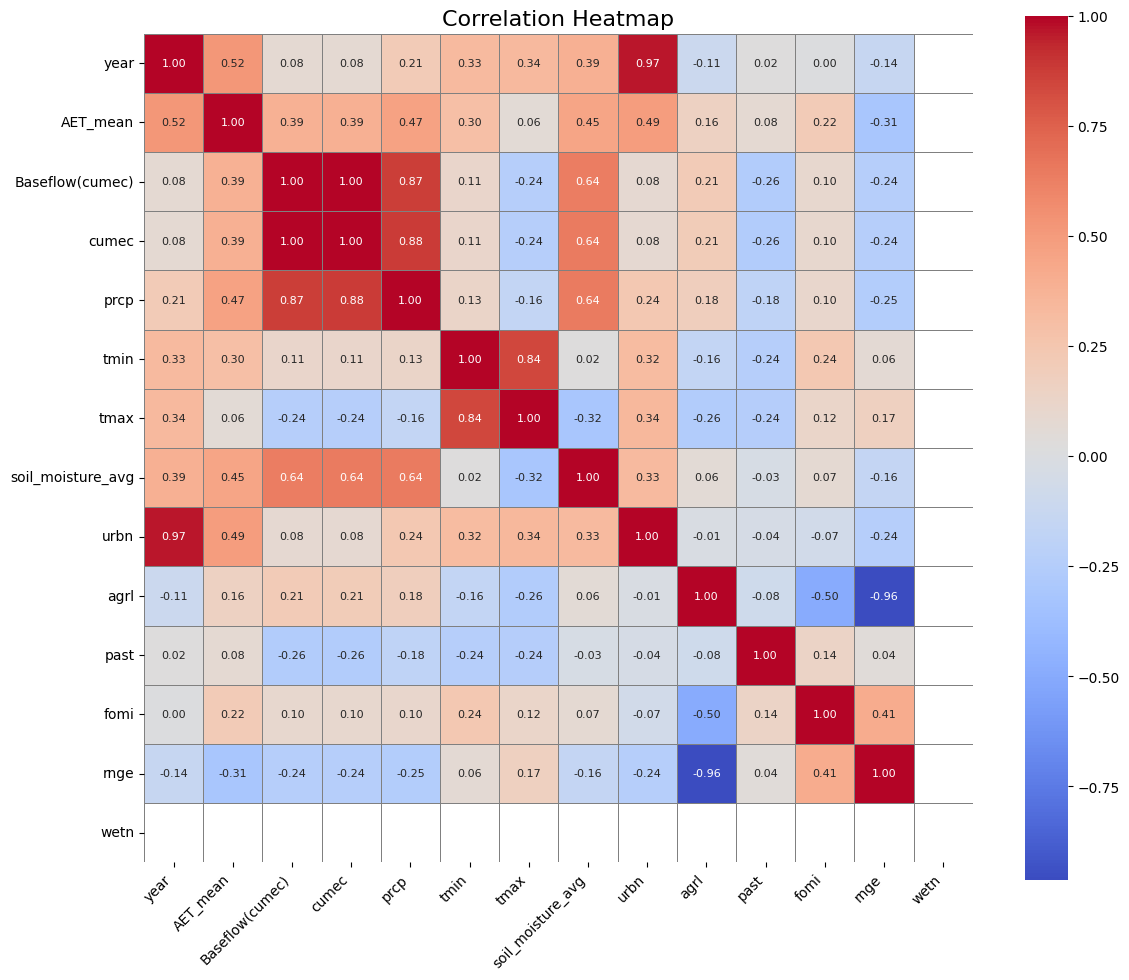

In [ ]:
df_corr = df.dropna(axis=1, how='all')
df_corr = df_corr.loc[:, df_corr.nunique() > 1]

numerical_feats = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_feats.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, cbar=True, linewidths=0.5, linecolor='gray',
            annot_kws={"size": 8}, mask=correlation_matrix.isnull())

plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

- **Streamflow**, **Baseflow(cumec)**, and **prcp** show strong positive correlations (ρ ≈ 0.88–1.00), indicating that precipitation and baseflow are key contributors to streamflow.

- **soil_moisture_avg** is moderately correlated with **streamflow **(ρ ≈ 0.64), suggesting that wetter soils enhance runoff and flow.

- **tmin** and **tmax** have a strong positive correlation (ρ ≈ 0.84), reflecting consistent temperature trends.

- **agrl (agricultural land)** shows weak to moderate negative correlations with streamflow (ρ ≈ -0.26) and very strong inverse relation with** mge (ρ ≈ -0.96)**, indicating possible land cover trade-offs.

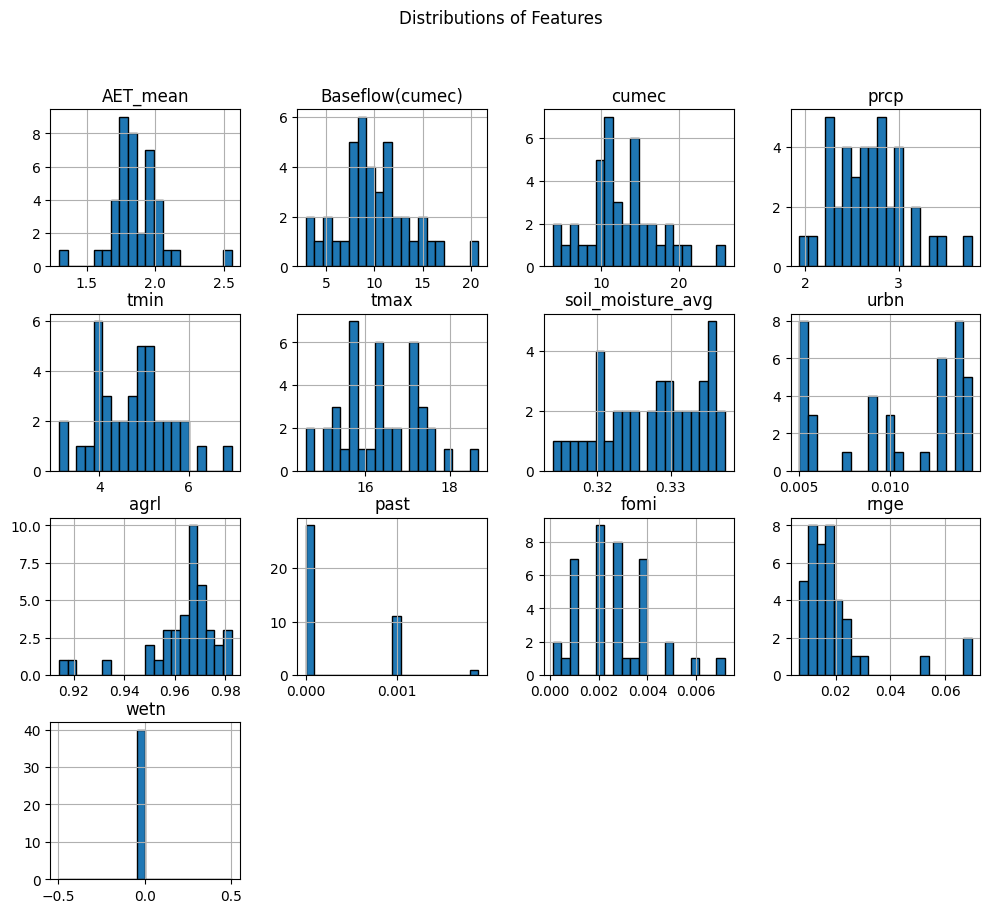

In [ ]:
# Histogram of each feature
df.drop(columns='year').hist(bins=20, figsize=(12, 10), edgecolor='black')
plt.suptitle("Distributions of Features")
plt.show()

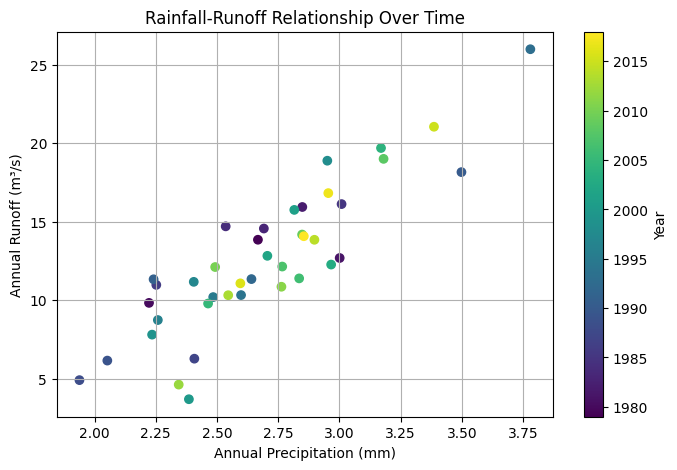

In [ ]:
#Plot rainfall-runoff relationship over time
plt.figure(figsize=(8, 5))
plt.scatter(df['prcp'], df['cumec'], c=df['year'], cmap='viridis')
plt.xlabel("Annual Precipitation (mm)")
plt.ylabel("Annual Runoff (m³/s)")
plt.title("Rainfall-Runoff Relationship Over Time")
plt.colorbar(label='Year')
plt.grid(True)
plt.show()

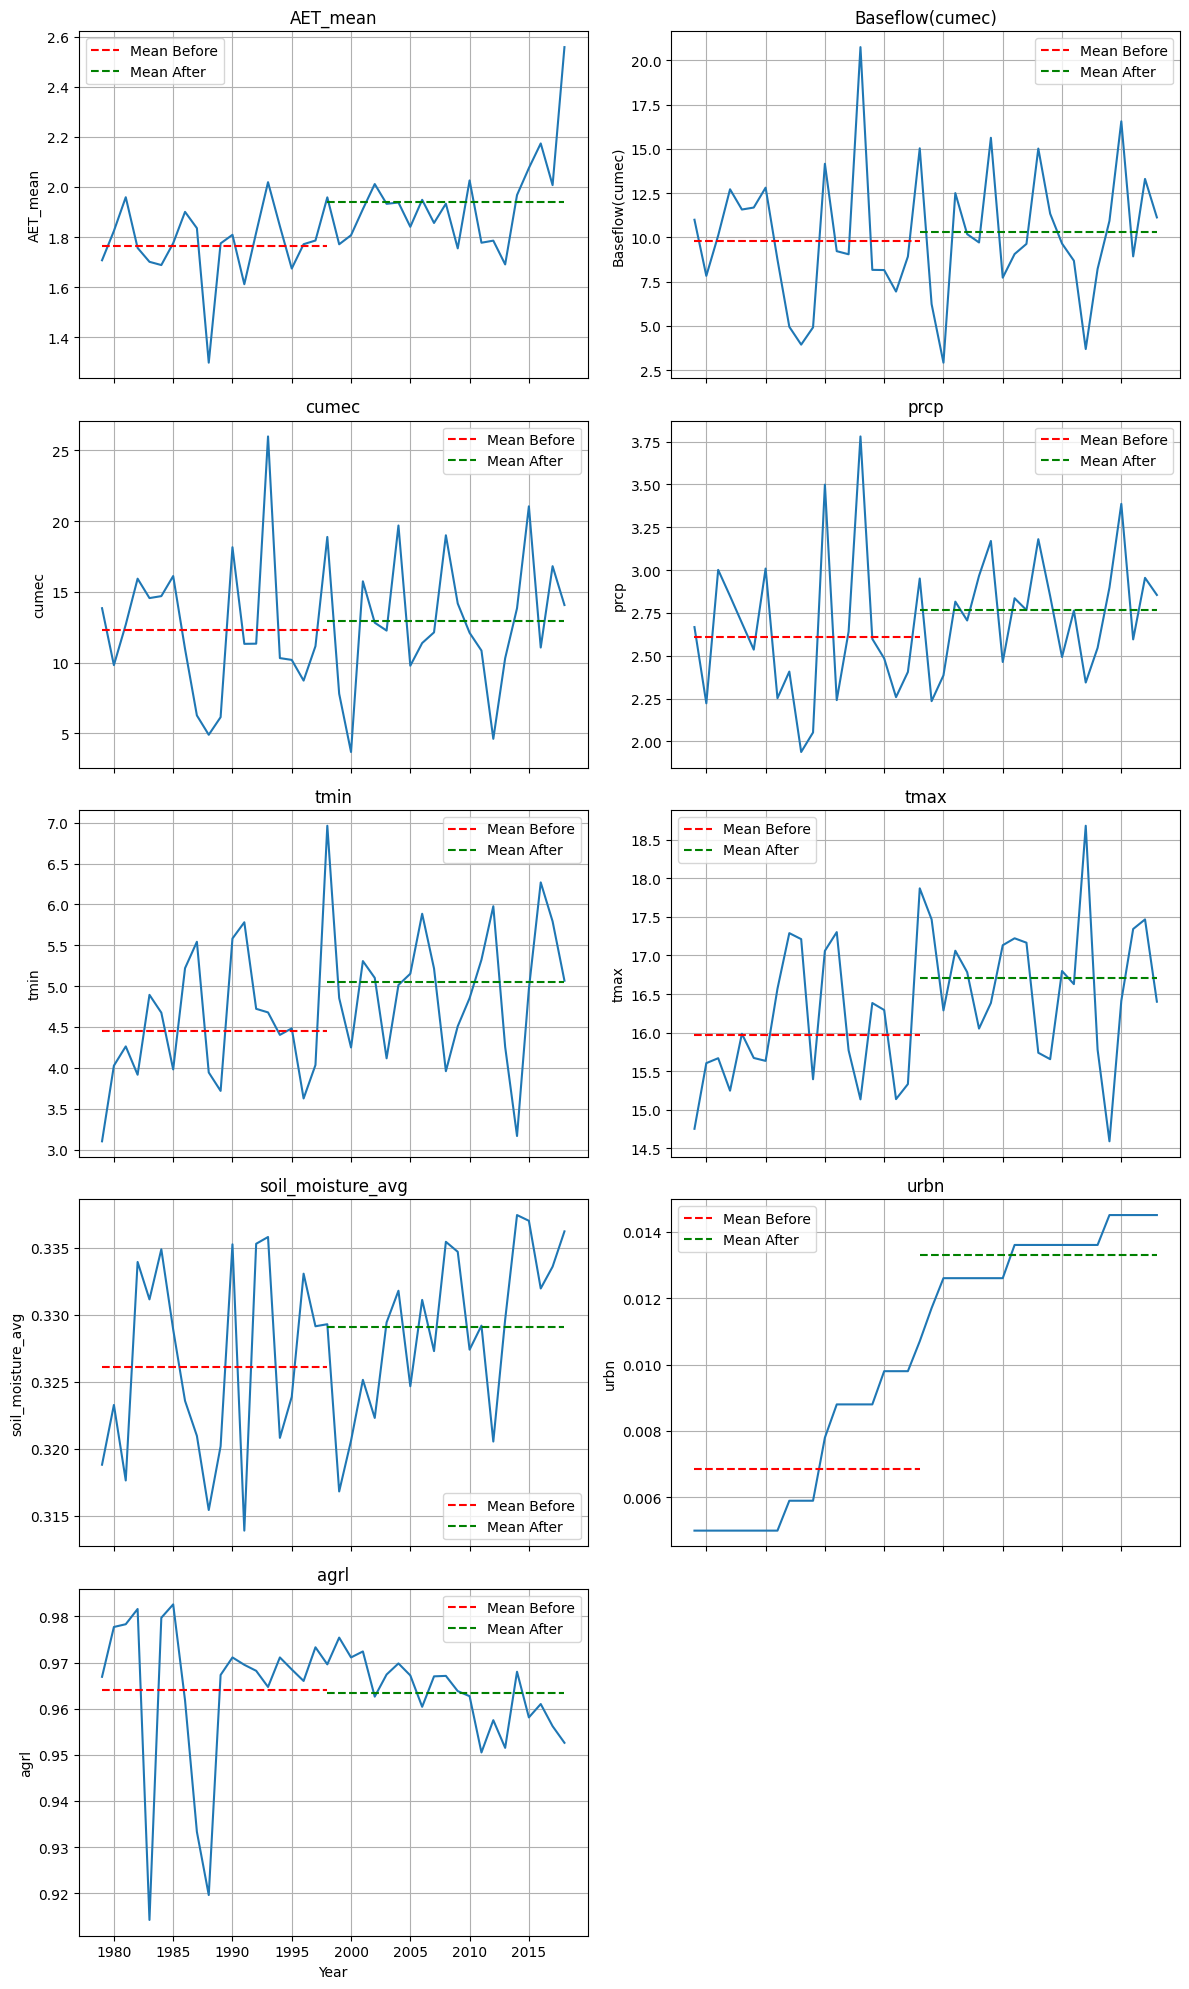

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['AET_mean','Baseflow(cumec)','cumec','prcp','tmin','tmax',
            'soil_moisture_avg','urbn','agrl']
change_point = 1998

n_features = len(features)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharex=True)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Plot line
    sns.lineplot(x=df['year'], y=df[feature], ax=ax)

    # Mean before/after change point
    mean_before = df[df['year'] < change_point][feature].mean()
    mean_after = df[df['year'] >= change_point][feature].mean()

    # Horizontal mean lines
    ax.hlines(mean_before, xmin=df['year'].min(), xmax=change_point, colors='red', linestyles='dashed', label='Mean Before')
    ax.hlines(mean_after, xmin=change_point, xmax=df['year'].max(), colors='green', linestyles='dashed', label='Mean After')

    ax.set_title(f"{feature}")
    ax.set_ylabel(feature)
    ax.grid(True)
    ax.legend()

# Remove unused subplots if features < total grid size
for j in range(i + 1, len(axes)):
     fig.delaxes(axes[j])
plt.xlabel("Year")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def seq_mk(data):
    """
    Sequential Mann-Kendall test.
    Input: 2-column NumPy array or DataFrame with [year, values]
    Output: DataFrame with columns [u_prog, u_retr, turning_point]
    """
    year = data[:, 0]
    values = data[:, 1]
    m = len(values)

    # Progressive series
    n = np.zeros((m, m))
    for j in range(m):
        for i in range(j):
            n[j, i] = 1 if values[j] > values[i] else 0
    num = np.sum(n, axis=1)
    t = np.cumsum(num)
    var = np.array([i * (i - 1) * (2 * i + 5) / 72 for i in range(1, m + 1)])
    mean = np.array([i * (i - 1) / 4 for i in range(1, m + 1)])
    u_prog = (t - mean) / np.sqrt(var)

    # Retrograde series
    values_rev = values[::-1]
    n1 = np.zeros((m, m))
    for j in range(m):
        for i in range(j):
            n1[j, i] = 1 if values_rev[j] > values_rev[i] else 0
    num1 = np.sum(n1, axis=1)
    t1 = np.cumsum(num1)
    var1 = var
    mean1 = mean
    u_retr = (t1 - mean1) / np.sqrt(var1)
    u_retr = u_retr[::-1]

    # Turning points
    diff = u_prog - u_retr
    turning_point = np.zeros(m)
    for i in range(1, m - 2):
        if np.sign(diff[i]) != np.sign(diff[i + 1]):
            turning_point[i + 1] = 1

    # Plot
    # plt.figure(figsize=(10, 5))
    # plt.plot(year, u_prog, 'r', label='Progressive Series')
    # plt.plot(year, u_retr, 'b', label='Retrograde Series')
    # plt.grid(True)
    # plt.title('Sequential Mann-Kendall Test')
    # plt.xlabel('Year')
    # plt.legend()
    # plt.show()

    return pd.DataFrame({
        'year': year,
        'u_prog': u_prog,
        'u_retr': u_retr,
        'turning_point': turning_point.astype(int)
    })


In [ ]:
#Applying S M Test to streamflow
df = pd.read_csv('df.csv')
data_array = df[['year', 'cumec']].to_numpy()
result = seq_mk(data_array)

# View detected change years
change_years = result[result['turning_point'] == 1]['year'].values
print("Non-stationary turning point years:", change_years)


Non-stationary turning point years: [1982. 1989. 1990. 1997. 1998. 2000. 2004. 2007. 2008. 2014. 2016. 2017.]


In [ ]:
features = ['AET_mean','Baseflow(cumec)','cumec','prcp','tmin','tmax',
            'soil_moisture_avg','urbn','agrl']

for feat in features:
    print(f"Testing variable: {feat}")
    data_array = df[['year', feat]].to_numpy()
    result = seq_mk(data_array)
    turning_years = result[result['turning_point'] == 1]['year'].values
    if len(turning_years) > 0:
        print("Turning points found in year(s):", turning_years)
    else:
        print("No turning point found.")
    print('\n')

Testing variable: AET_mean
No turning point found.


Testing variable: Baseflow(cumec)
Turning point(s) found in year(s): [1982. 1989. 1990. 1997. 1998. 2000. 2004. 2014. 2016. 2017.]


Testing variable: cumec
Turning point(s) found in year(s): [1982. 1989. 1990. 1997. 1998. 2000. 2004. 2007. 2008. 2014. 2016. 2017.]


Testing variable: prcp
Turning point(s) found in year(s): [1989. 1990. 2000. 2003.]


Testing variable: tmin
No turning point found.


Testing variable: tmax
No turning point found.


Testing variable: soil_moisture_avg
No turning point found.


Testing variable: urbn
No turning point found.


Testing variable: agrl
No turning point found.




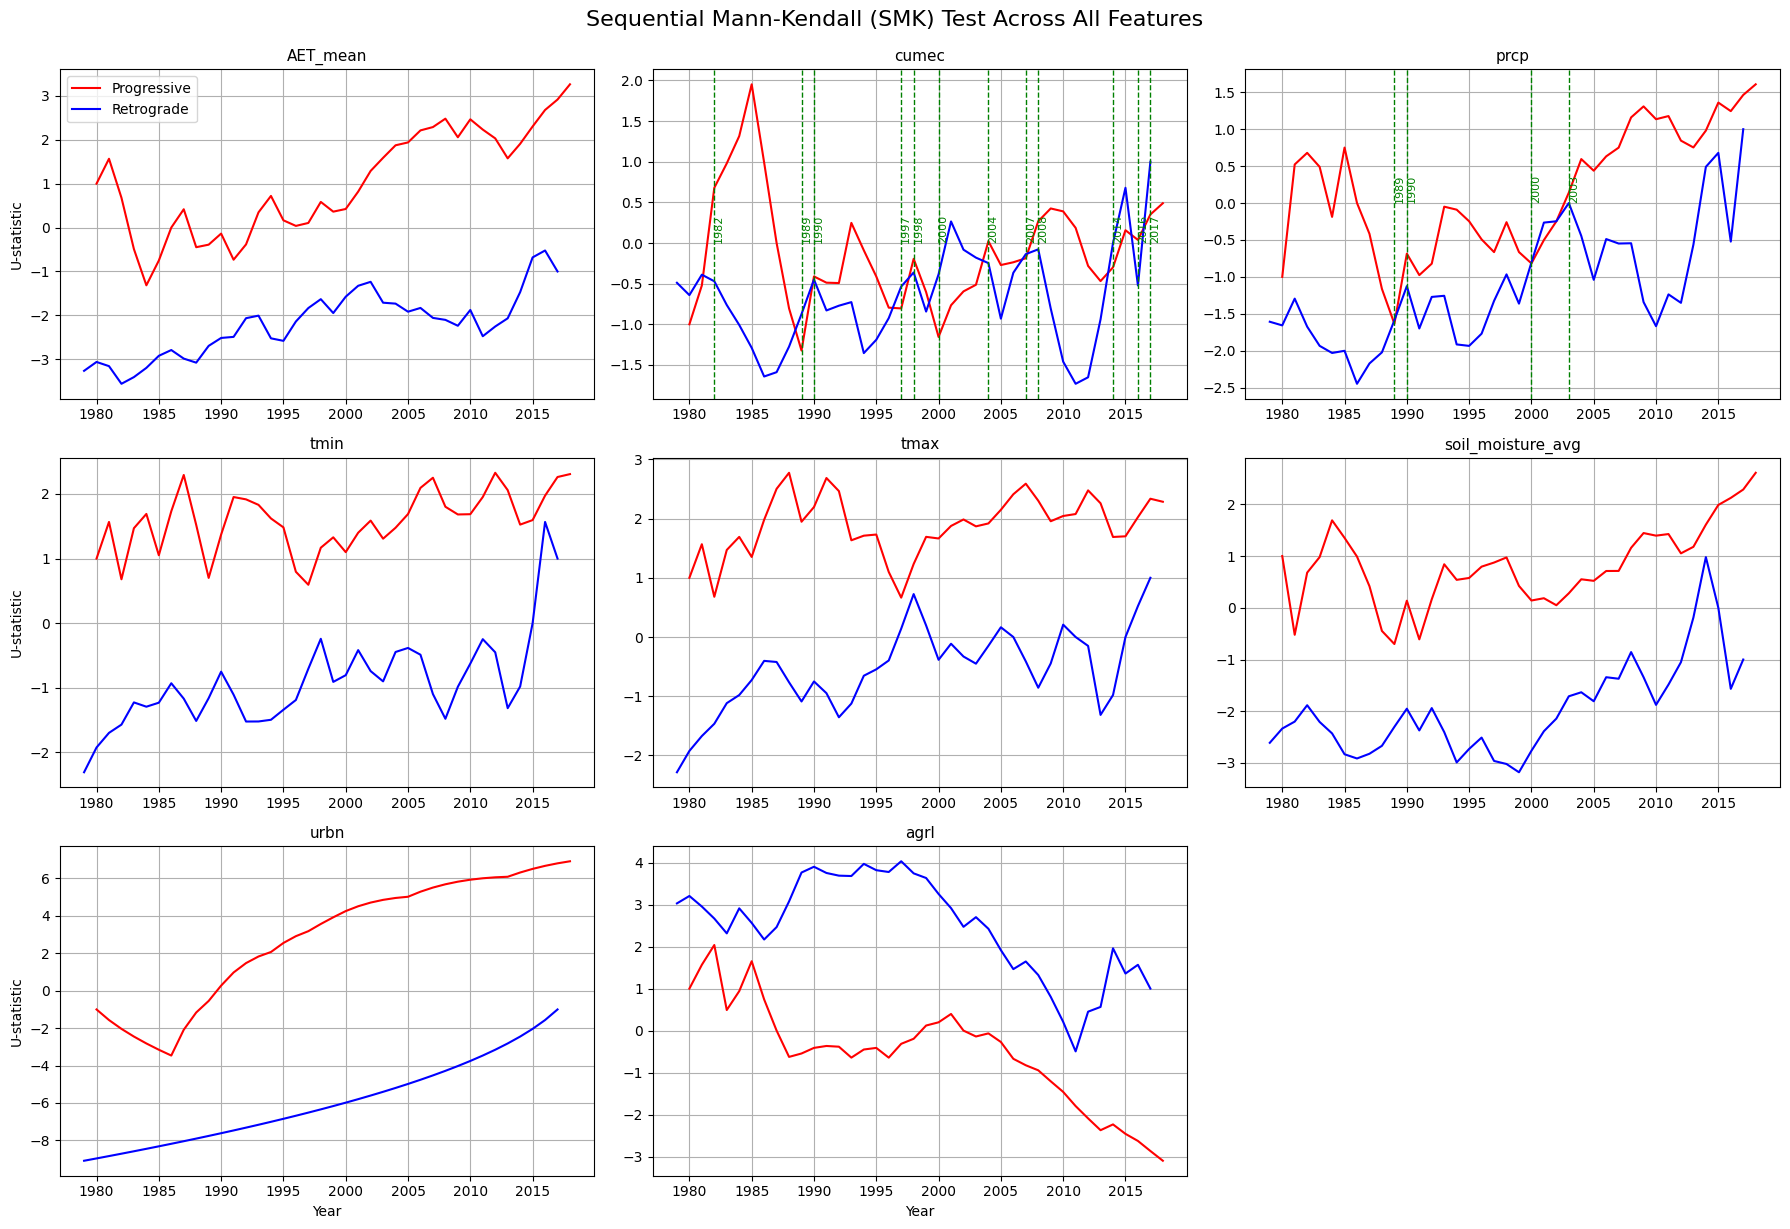

In [ ]:
df = pd.read_csv("df.csv")

# List of features to analyze
features = ['AET_mean', 'cumec', 'prcp', 'tmin', 'tmax',
            'soil_moisture_avg', 'urbn', 'agrl']

# Plot configuration
cols = 3
rows = math.ceil(len(features) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
axes = axes.flatten()

# Sequential MK for each feature
for idx, feature in enumerate(features):
    ax = axes[idx]
    data_array = df[['year', feature]].to_numpy()
    result = seq_mk(data_array)

    year = result['year']
    u_prog = result['u_prog']
    u_retr = result['u_retr']
    turning_years = result[result['turning_point'] == 1]['year'].values

    ax.plot(year, u_prog, 'r', label='Progressive')
    ax.plot(year, u_retr, 'b', label='Retrograde')

    for ty in turning_years:
        ax.axvline(ty, color='green', linestyle='--', linewidth=1)
        ax.text(ty, 0, f'{int(ty)}', color='green', fontsize=8, rotation=90, va='bottom')

    ax.set_title(f"{feature}", fontsize=11)
    ax.grid(True)

    if idx % cols == 0:
        ax.set_ylabel("U-statistic")
    if idx >= (rows - 1) * cols:
        ax.set_xlabel("Year")

# Remove empty subplots if any
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

# Final touches
fig.tight_layout()
fig.suptitle("Sequential Mann-Kendall (SMK) Test Across All Features", fontsize=16, y=1.02)
axes[0].legend()
plt.show()

In [ ]:
df['urban_precip'] = df['urbn'] * df['prcp']
df['urban_tmin'] = df['urbn'] * df['tmin']

# Model training

In [ ]:
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# data
df = df.copy()

# Define target and features
target = 'cumec'
features = [col for col in df.columns if col not in ['year', target, 'Baseflow(cumec)']]

# Change point
change_point = 1998
df_before = df[df['year'] <= change_point]
df_after = df[df['year'] > change_point]

X = df[features]
y = df[target]
X_before = df_before[features]
y_before = df_before[target]
X_after = df_after[features]
y_after = df_after[target]

### Hyper parameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Param grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.7, 1]
}

xgb_model = XGBRegressor(random_state=42)
grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                    scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
grid.fit(X, y)

# Best model
best_model = grid.best_estimator_
print("Best Params:", grid.best_params_)
print("Best Score (RMSE):", np.sqrt(-grid.best_score_))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Params: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best Score (RMSE): 2.8923674349513475


In [ ]:
df.sample()

,year,AET_mean,Baseflow(cumec),cumec,prcp,tmin,tmax,soil_moisture_avg,urbn,agrl,past,fomi,rnge,wetn,urban_precip,urban_tmin
9,1988,1.298331,3.936125,4.898861,1.938119,3.943385,17.211156,0.315423,0.0059,0.9196,0.0,0.0029,0.0678,0.0038,0.011435,0.023266


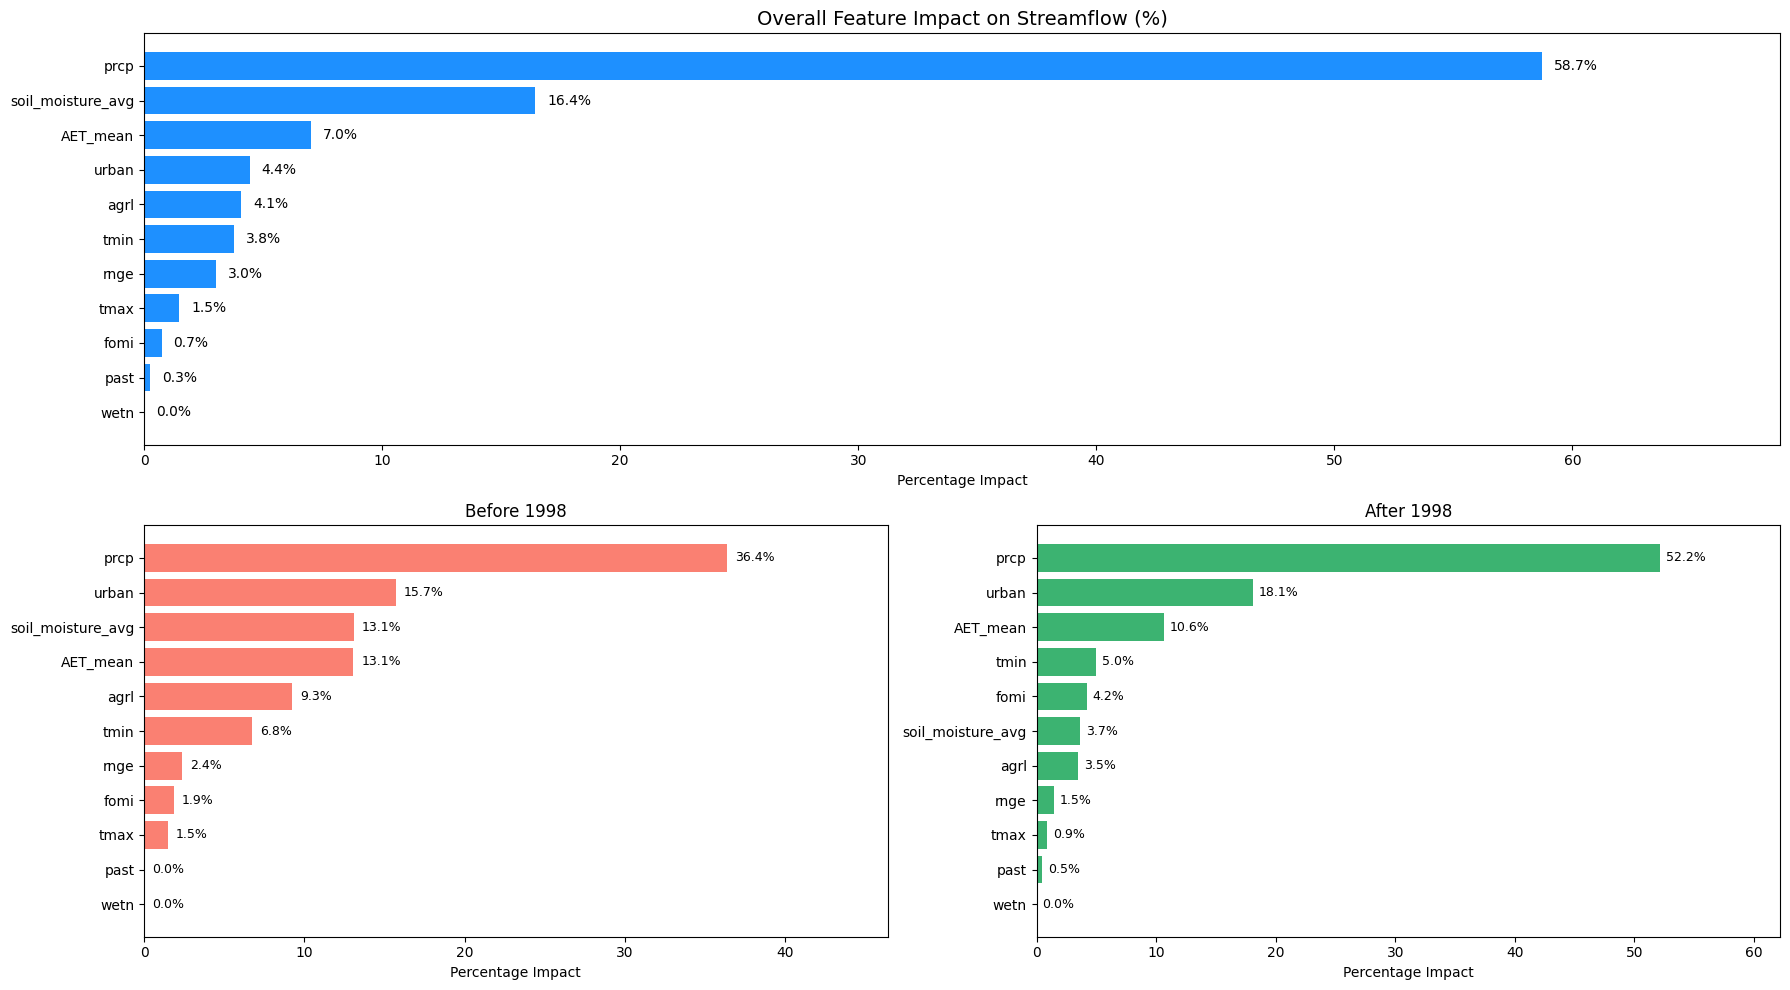

In [ ]:
'''Best Params: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best Score (RMSE): 2.8923674349513475
'''
# # Train Models
# Extract best params
best_params = grid.best_params_

# Refit all models
model_full = XGBRegressor(**best_params, random_state=42)
model_full.fit(X, y)

model_before = XGBRegressor(**best_params, random_state=42)
model_before.fit(X_before, y_before)

model_after = XGBRegressor(**best_params, random_state=42)
model_after.fit(X_after, y_after)

# Use SHAP TreeExplainer
explainer_full = shap.TreeExplainer(model_full)
explainer_before = shap.TreeExplainer(model_before)
explainer_after = shap.TreeExplainer(model_after)

shap_values_full = explainer_full.shap_values(X)
shap_values_before = explainer_before.shap_values(X_before)
shap_values_after = explainer_after.shap_values(X_after)

# Feature importance calculation
def get_percentage_impact(shap_vals, columns, group_map):
    # Map columns to groups
    df = pd.DataFrame(shap_vals, columns=columns)

    # Initialize a dict to store group-wise impact
    grouped_shap = {}
    for group_name, feature_list in group_map.items():
        grouped_shap[group_name] = df[feature_list].abs().sum(axis=1)

    # Add other features not in any group
    for col in columns:
        if not any(col in v for v in group_map.values()):
            grouped_shap[col] = df[col].abs()

    grouped_df = pd.DataFrame(grouped_shap)
    mean_abs = grouped_df.mean()
    pct = 100 * mean_abs / mean_abs.sum()
    return pct.sort_values()
# Aggregating all the urban into a single map
group_map = {
    "urban": ["urban_precip", "urbn", "urban_tmin"]
}

# Calculate
imp_full = get_percentage_impact(shap_values_full, features, group_map)
imp_before = get_percentage_impact(shap_values_before, features, group_map)
imp_after = get_percentage_impact(shap_values_after, features, group_map)

# Plotting
fig = plt.figure(figsize=(18, 10))

# Full dataset
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1.barh(imp_full.index, imp_full.values, color='dodgerblue')
ax1.set_title("Overall Feature Impact on Streamflow (%)", fontsize=14)
for i, v in enumerate(imp_full.values):
    ax1.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=10)
ax1.set_xlim(0, imp_full.values.max() + 10)
ax1.set_xlabel("Percentage Impact")

# Before
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax2.barh(imp_before.index, imp_before.values, color='salmon')
ax2.set_title(f"Before {change_point}", fontsize=12)
for i, v in enumerate(imp_before.values):
    ax2.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=9)
ax2.set_xlim(0, imp_before.values.max() + 10)
ax2.set_xlabel("Percentage Impact")

# After
ax3 = plt.subplot2grid((2, 2), (1, 1))
ax3.barh(imp_after.index, imp_after.values, color='mediumseagreen')
ax3.set_title(f"After {change_point}", fontsize=12)
for i, v in enumerate(imp_after.values):
    ax3.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=9)
ax3.set_xlim(0, imp_after.values.max() + 10)
ax3.set_xlabel("Percentage Impact")

plt.tight_layout()
plt.show()

In [ ]:
print("Before Correlation with Target:")
print(df_before.corr()['cumec']['urbn'])

print("After Correlation with Target:")
print(df_after.corr()['cumec']['urbn'])


Before Correlation with Target:
0.14152709838828742
After Correlation with Target:
0.3304089086866252


## Monthly analysis

In [ ]:
# ======Data Cleaning ======
aet_df['date'] = pd.to_datetime(aet_df['date'])
streamflow_df['date'] = pd.to_datetime(streamflow_df['date'], format='%m/%d/%Y')
baseflow_df['date'] = pd.to_datetime(baseflow_df['date'], format='%m/%d/%Y')
climate_df['date'] = pd.to_datetime(climate_df['date'])

#  Extract year and month for monthly grouping
for df in [aet_df, streamflow_df, baseflow_df, climate_df]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

# Group by year and month
aet_monthly = aet_df.groupby(['year', 'month'])['AET_mean'].mean().reset_index()
streamflow_monthly = streamflow_df.groupby(['year', 'month'])['cumec'].mean().reset_index()
baseflow_monthly = baseflow_df.groupby(['year', 'month'])['Baseflow(cumec)'].mean().reset_index()
climate_monthly = climate_df.groupby(['year', 'month']).agg({
    'prcp': 'mean',
    'tmin': 'mean',
    'tmax': 'mean'
}).reset_index()


In [ ]:
# Find soil moisture CSVs
soil_files = [os.path.join(base_path, f) for f in os.listdir(base_path)
              if f.startswith("SW_ID_") and f.endswith(".csv")]

# Process each file
soil_dfs = []
for i, path in enumerate(soil_files):
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df_monthly = df.groupby(['year', 'month'])['soil_moisture'].mean().reset_index()
    df_monthly.columns = ['year', 'month', f'soil_{8795+i}']
    soil_dfs.append(df_monthly)

# Merge and average
soil_combined = soil_dfs[0]
for df in soil_dfs[1:]:
    soil_combined = soil_combined.merge(df, on=['year', 'month'], how='outer')
soil_combined['soil_moisture_avg'] = soil_combined.iloc[:, 2:5].mean(axis=1)
soil_monthly = soil_combined[['year', 'month', 'soil_moisture_avg']]


In [ ]:
# ===== LULC =====
lulc_monthly = lulc_df.loc[lulc_df.index.repeat(12)].copy()
lulc_monthly['month'] = list(range(1, 13)) * lulc_df.shape[0]
lulc_monthly = lulc_monthly.sort_values(['year', 'month']).reset_index(drop=True)


In [ ]:
df_monthly = aet_monthly \
    .merge(baseflow_monthly, on=['year', 'month']) \
    .merge(streamflow_monthly, on=['year', 'month']) \
    .merge(climate_monthly, on=['year', 'month']) \
    .merge(soil_monthly, on=['year', 'month']) \
    .merge(lulc_monthly, on=['year', 'month'])

df_monthly = df_monthly.dropna()

df_monthly = aet_monthly \
    .merge(baseflow_monthly, on=['year', 'month']) \
    .merge(streamflow_monthly, on=['year', 'month']) \
    .merge(climate_monthly, on=['year', 'month']) \
    .merge(soil_monthly, on=['year', 'month']) \
    .merge(lulc_monthly, on=['year', 'month'])

df_monthly = df_monthly.dropna()

print(f"Shape: {df_monthly.shape}")
print('\n')
print(df_monthly.head())

Shape: (475, 18)


   year  month  AET_mean  Baseflow(cumec)      cumec      prcp       tmin  \
0  1979      1  0.149707         0.796763   0.989261  2.345758 -15.820885   
1  1979      2  0.266840         0.982058   1.298528  0.752755 -15.052949   
2  1979      3  0.659850        42.148799  54.218451  3.556901  -1.460991   
3  1979      4  1.191405        39.326594  48.739820  5.035615   2.981844   
4  1979      5  2.748628        11.549750  13.749177  2.013299   8.550293   

        tmax  soil_moisture_avg   urbn    agrl   past    fomi  rngb    rnge  \
0  -6.014986           0.293814  0.005  0.9669  0.001  0.0038   0.0  0.0196   
1  -4.491970           0.319374  0.005  0.9669  0.001  0.0038   0.0  0.0196   
2   8.433387           0.367721  0.005  0.9669  0.001  0.0038   0.0  0.0196   
3  13.858047           0.365288  0.005  0.9669  0.001  0.0038   0.0  0.0196   
4  22.663907           0.335309  0.005  0.9669  0.001  0.0038   0.0  0.0196   

   wehb    wetn  bsvg  
0   0.0  0.0038   0

In [ ]:
print(df_monthly.isnull().sum())
print('\n')
print(df_monthly.info())

year                 0
month                0
AET_mean             0
Baseflow(cumec)      0
cumec                0
prcp                 0
tmin                 0
tmax                 0
soil_moisture_avg    0
urbn                 0
agrl                 0
past                 0
fomi                 0
rngb                 0
rnge                 0
wehb                 0
wetn                 0
bsvg                 0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               475 non-null    int32  
 1   month              475 non-null    int32  
 2   AET_mean           475 non-null    float64
 3   Baseflow(cumec)    475 non-null    float64
 4   cumec              475 non-null    float64
 5   prcp               475 non-null    float64
 6   tmin               475 non-null    float64
 7   tmax               475 non-nu

In [ ]:
print(df_monthly.describe())

              year       month    AET_mean  Baseflow(cumec)       cumec  \
count   475.000000  475.000000  475.000000       475.000000  475.000000   
mean   1998.368421    6.469474    1.859481        10.041182   12.630861   
std      11.477232    3.439135    1.510696        10.765608   13.592347   
min    1979.000000    1.000000    0.146488         0.096447    0.120913   
25%    1988.500000    3.500000    0.448518         1.645870    2.080825   
50%    1998.000000    6.000000    1.390508         6.354023    7.967069   
75%    2008.000000    9.000000    3.091897        14.071668   17.866729   
max    2018.000000   12.000000    5.610427        49.132883   61.932617   

             prcp        tmin        tmax  soil_moisture_avg        urbn  \
count  475.000000  475.000000  475.000000         475.000000  475.000000   
mean     2.685842    4.793013   16.409142           0.327628    0.010208   
std      1.566943    9.225901   10.636461           0.026867    0.003558   
min      0.000000  -